Author: Akshay Chougule

Creation Date: 15-Feb-2020

Description: This is a v7 of notebook for Human-Protein-Atlas-Competition.

Change log: 
- We start with RGB images generated w/o Yellow file information. 
- We try both metrci F1-beta and F1-macro. 
- Maybe we wil use v3 saved model: nb-v3-resnet34-stage2-F1-macro. do stage 1 and stage 2 operations

In [1]:
import pandas as pd
import wget
import time
import os
import copy

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [3]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *

In [4]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [5]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


__Create the databunch__

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
#                     brightness(scale=(0.4, 0.6)), 
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.15, xtra_tfms=additional_aug)

In [8]:
test = ImageList.from_csv(data_root,'sample_submission.csv',folder='test_512by512_no_Y',suffix='.png')

In [9]:
src = (ImageList.from_csv(data_root,'train.csv',folder='train_512by512_no_Y',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' ')
       .add_test(test))

In [10]:
src.train.databunch

<bound method LabelList.databunch of LabelList (24858 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
16;0,7;1;2;0,1,18,0
Path: /home/ubuntu/datasets/human-protein-atlas>

In [11]:
src.valid.databunch

<bound method LabelList.databunch of LabelList (6214 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
25;21,3;0,7;0,25;0;21,23
Path: /home/ubuntu/datasets/human-protein-atlas>

In [12]:
src.test.databunch

<bound method LabelList.databunch of LabelList (11702 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/datasets/human-protein-atlas>

^ that looks correct. We have 80% of the images in train and 20% in validation databunch as specified. Alos the test data count match.

In [13]:
data = (src.transform(tfms, size=512)
        .databunch(bs = 32).normalize(imagenet_stats))

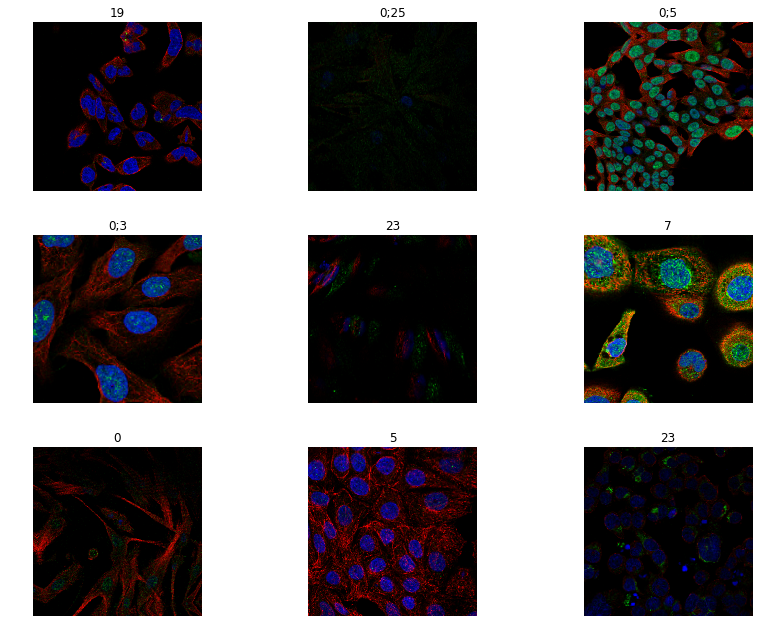

In [14]:
data.show_batch(rows=3, figsize=(12,9))

In [28]:
arch = models.resnet18
# part 1 with fbeta
f1_score = partial(fbeta, thresh=0.2, beta=1)
# part 2 with f1 macro
f1_macro = MultiLabelFbeta(beta=2, average="macro")

In [29]:
setattr(src, 'device', 'cuda') 

### PART 1: f1macro as metrics

In [33]:
learn = cnn_learner(data, arch, metrics=f1_macro)

In [34]:
learn.data.batch_size

32

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


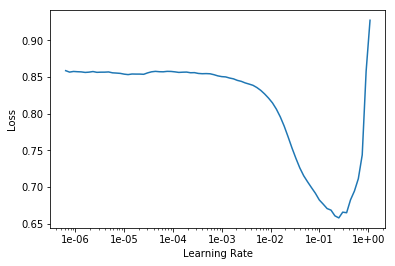

In [36]:
learn.recorder.plot()

In [37]:
lr = 0.01

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.153330,0.142118,0.164775,02:33
1,0.135998,0.129251,0.223632,02:35
2,0.127500,0.118598,0.272951,02:34
3,0.123538,0.113559,0.297865,02:35
4,0.118969,0.112161,0.306893,02:35


In [39]:
learn.save('nb-v7-resnet18-stage1-F1-beta') # This actually macro

In [40]:
learn.unfreeze()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


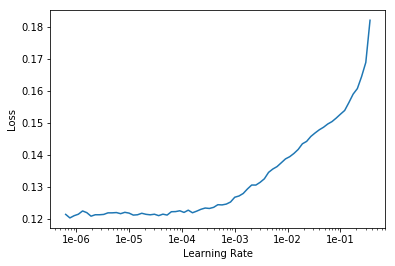

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.119062,0.110303,0.319506,03:33
1,0.117161,0.108929,0.336263,03:32
2,0.114110,0.109462,0.333423,03:34
3,0.110688,0.108041,0.328084,03:34
4,0.107523,0.100586,0.385625,03:34
5,0.103235,0.098241,0.417955,03:32
6,0.101356,0.096377,0.402379,03:31
7,0.098815,0.094675,0.459869,03:32
8,0.093069,0.091816,0.453103,03:31
9,0.091324,0.089832,0.489105,03:32


In [43]:
learn.save('nb-v7-resnet18-stage2-F1-beta') # This actually macro

__Making the predictions__

In [44]:
preds, _ = learn.get_preds(DatasetType.Test)

fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/','')
sample_submission = pd.read_csv(data_root+'sample_submission.csv')

In [45]:
learn.data.test_ds.items

array(['/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png', ...,
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/fff03816-bad5-11e8-b2b9-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0.png'],
      dtype='<U101')

Let's try playing around with the threshold

In [46]:
thresholds = [0.18,0.16,0.14,0.12,0.10]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_nb-V7.1_stage2_thresh_'+str(thresh)+'.csv', header=True, index=False)

In [47]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.18.csv -m "Model v7.1 with resnet18 stage-2 and thrsd 0.18"

100%|█████████████████████████████████████████| 486k/486k [00:00<00:00, 625kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [48]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.16.csv -m "Model v7.1 with resnet18 stage-2 and thrsd 0.16"

100%|█████████████████████████████████████████| 490k/490k [00:00<00:00, 602kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [49]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.14.csv -m "Model v7.1 with resnet18 stage-2 and thrsd  0.14"

100%|█████████████████████████████████████████| 494k/494k [00:00<00:00, 726kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [50]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.12.csv -m "Model v7.1 with resnet18 stage-2 and thrsd 0.12"

100%|█████████████████████████████████████████| 500k/500k [00:00<00:00, 852kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [51]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.1.csv -m "Model v7.1 with resnet18 stage-2 and thrsd  0.1"

100%|█████████████████████████████████████████| 507k/507k [00:00<00:00, 694kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [52]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!head results.txt

fileName                                               date                 description                                       status    publicScore  privateScore  
-----------------------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
protein_classification_nb-V7.1_stage2_thresh_0.1.csv   2020-02-15 21:20:33  Model v7.1 with resnet18 stage-2 and thrsd  0.1   complete  0.38322      0.37456       
protein_classification_nb-V7.1_stage2_thresh_0.12.csv  2020-02-15 21:20:31  Model v7.1 with resnet18 stage-2 and thrsd 0.12   complete  0.38777      0.36940       
protein_classification_nb-V7.1_stage2_thresh_0.14.csv  2020-02-15 21:20:29  Model v7.1 with resnet18 stage-2 and thrsd  0.14  complete  0.39021      0.37315       
protein_classification_nb-V7.1_stage2_thresh_0.16.csv  2020-02-15 21:20:27  Model v7.1 with resnet18 stage-2 and thrsd 0.16   complete  0.38714      0.37214       
protein_classifi

In [59]:
thresholds = [0.09,0.08,0.07,0.06]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_nb-V7.1_stage2_thresh_'+str(thresh)+'.csv', header=True, index=False)

In [60]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.09.csv -m "Model v7.1 with resnet18 stage-2 and thrsd 0.09"

100%|████████████████████████████████████████| 511k/511k [00:00<00:00, 1.03MB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [61]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.08.csv -m "Model v7.1 with resnet18 stage-2 and thrsd 0.08"

100%|█████████████████████████████████████████| 515k/515k [00:00<00:00, 906kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [62]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.07.csv -m "Model v7.1 with resnet18 stage-2 and thrsd 0.07"

100%|█████████████████████████████████████████| 521k/521k [00:00<00:00, 870kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [63]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.1_stage2_thresh_0.06.csv -m "Model v7.1 with resnet18 stage-2 and thrsd 0.06"

100%|████████████████████████████████████████| 528k/528k [00:00<00:00, 1.07MB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [64]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!head results.txt

fileName                                               date                 description                                       status    publicScore  privateScore  
-----------------------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
protein_classification_nb-V7.1_stage2_thresh_0.06.csv  2020-02-15 22:02:12  Model v7.1 with resnet18 stage-2 and thrsd 0.06   complete  0.37016      0.36276       
protein_classification_nb-V7.1_stage2_thresh_0.07.csv  2020-02-15 22:02:10  Model v7.1 with resnet18 stage-2 and thrsd 0.07   complete  0.37746      0.36341       
protein_classification_nb-V7.1_stage2_thresh_0.08.csv  2020-02-15 22:02:08  Model v7.1 with resnet18 stage-2 and thrsd 0.08   complete  0.38382      0.36838       
protein_classification_nb-V7.1_stage2_thresh_0.09.csv  2020-02-15 22:02:05  Model v7.1 with resnet18 stage-2 and thrsd 0.09   complete  0.38758      0.37190       
protein_classifi

## PART 2: f1-beta as metrics

In [69]:
learn = cnn_learner(data, arch, metrics=f1_score)

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


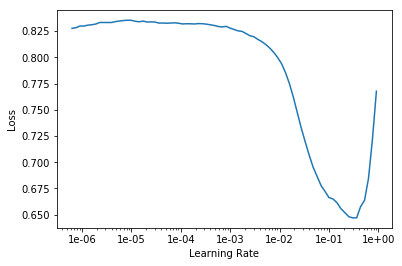

In [70]:
learn.lr_find()
learn.recorder.plot()

In [71]:
lr = 0.01/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta,time
0,0.154668,0.143948,0.447449,02:33
1,0.139165,0.129657,0.516785,02:34
2,0.131487,0.121942,0.554620,02:35
3,0.125265,0.117303,0.581122,02:35
4,0.123479,0.116247,0.579103,02:33


In [72]:
learn.save('nb-v7-resnet18-stage1-F1-beta')

In [73]:
learn.unfreeze()

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


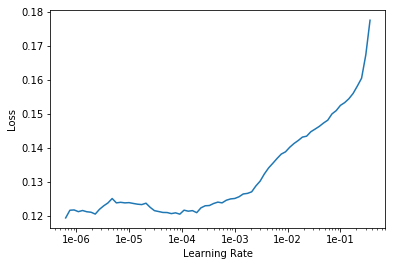

In [74]:
learn.lr_find()
learn.recorder.plot()

In [75]:
learn.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,time
0,0.120019,0.113957,0.590529,03:31
1,0.119734,0.111674,0.598630,03:33
2,0.114919,0.109680,0.612822,03:33
3,0.109521,0.107046,0.620959,03:32
4,0.108639,0.104845,0.628968,03:31
5,0.105318,0.098409,0.656340,03:31
6,0.101383,0.096846,0.668404,03:31
7,0.096664,0.094351,0.677504,03:32
8,0.096233,0.092503,0.677209,03:32
9,0.088440,0.089994,0.691193,03:32


In [79]:
learn.save('nb-v7-resnet18-stage2-F1-beta')

In [77]:
preds, _ = learn.get_preds(DatasetType.Test)

fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/','')
sample_submission = pd.read_csv(data_root+'sample_submission.csv')

In [78]:
thresholds = [0.2,0.18,0.16,0.14,0.12,0.10,0.09,0.08,0.07]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512_no_Y/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_nb-V7.2_stage2_thresh_'+str(thresh)+'.csv', header=True, index=False)

In [80]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.2.csv -m "Model v7.2 with resnet18 stage-2 and thrsd 0.2"

100%|█████████████████████████████████████████| 483k/483k [00:01<00:00, 366kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [81]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.18.csv -m "Model v7.2 with resnet18 stage-2 and thrsd 0.18"

100%|█████████████████████████████████████████| 486k/486k [00:00<00:00, 800kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [82]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.16.csv -m "Model v7.2 with resnet18 stage-2 and thrsd 0.16"

100%|█████████████████████████████████████████| 490k/490k [00:00<00:00, 803kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [83]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.14.csv -m "Model v7.2 with resnet18 stage-2 and thrsd  0.14"

100%|█████████████████████████████████████████| 494k/494k [00:00<00:00, 834kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [84]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.12.csv -m "Model v7.2 with resnet18 stage-2 and thrsd 0.12"

100%|█████████████████████████████████████████| 499k/499k [00:00<00:00, 805kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [85]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.1.csv -m "Model v7.2 with resnet18 stage-2 and thrsd  0.1"

100%|█████████████████████████████████████████| 506k/506k [00:00<00:00, 884kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [86]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.09.csv -m "Model v7.2 with resnet18 stage-2 and thrsd  0.09"

100%|█████████████████████████████████████████| 511k/511k [00:00<00:00, 692kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [87]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.08.csv -m "Model v7.2 with resnet18 stage-2 and thrsd  0.08"

100%|█████████████████████████████████████████| 516k/516k [00:00<00:00, 790kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [88]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V7.2_stage2_thresh_0.07.csv -m "Model v7.2 with resnet18 stage-2 and thrsd  0.07"

100%|█████████████████████████████████████████| 521k/521k [00:00<00:00, 762kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [89]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!head results.txt

fileName                                               date                 description                                       status    publicScore  privateScore  
-----------------------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
protein_classification_nb-V7.2_stage2_thresh_0.07.csv  2020-02-16 00:18:26  Model v7.2 with resnet18 stage-2 and thrsd  0.07  complete  0.37018      0.36459       
protein_classification_nb-V7.2_stage2_thresh_0.08.csv  2020-02-16 00:18:24  Model v7.2 with resnet18 stage-2 and thrsd  0.08  complete  0.37632      0.37276       
protein_classification_nb-V7.2_stage2_thresh_0.09.csv  2020-02-16 00:18:22  Model v7.2 with resnet18 stage-2 and thrsd  0.09  complete  0.37979      0.37343       
protein_classification_nb-V7.2_stage2_thresh_0.1.csv   2020-02-16 00:18:17  Model v7.2 with resnet18 stage-2 and thrsd  0.1   complete  0.38242      0.37703       
protein_classifi